# Map 3D data

We will map using noisy data, where the "truth" function is 
$$
f(x) = sin(kx+ly - \omega t)
$$

We purposefully added a time dimension, since we are trying to map Argo data along the time axis too. 

In [1]:
import george as grg
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
np.random.seed(1234);
xr.set_options(display_style='html');

In [3]:
def fake_3d_data(n_samples, rangex=1, rangey=1, ranget=1, k=2*np.pi, l=2*np.pi, om=2*np.pi, eta=0.1):
    
    # generate a vector that has n_samples rows and 3 rows corresponding to x,y,t
    xND = np.random.rand(n_samples, 3)
    
    # Since the above vector was generated using uniform distributions that vary between 0,1
    # we now rescale them to dimensionalize them (ex. if we want x to vary between 0-10, we set rangex=10)
    x = xND
    x[:,0] = rangex*x[:,0]
    x[:,1] = rangey*x[:,1]
    x[:,2] = ranget*x[:,2]
        
    # convert to xarray since we will be getting the argo data in this form
    x = xr.DataArray(x,  dims=["samplenum", "coordinate"], coords=[range(n_samples), ['x','y','t']])
    
    # generate some random uncorrelated noise with a gaussian distribution
    # This will be added to each sample, and corresponds to the observational noise 
    yerr = eta * np.random.randn(n_samples)
    
    y = np.sin(k*x.sel(coordinate='x') + l*x.sel(coordinate='y') - om*x.sel(coordinate='t')) + yerr
    
    return x, y

In [10]:
# Generate a fake data set at some random sample points.
eta = 0.1
[x,y] = fake_3d_data(1200, 10,10,2, 1, 1.5 , 2*np.pi, eta)

Text(0, 0.5, 'y')

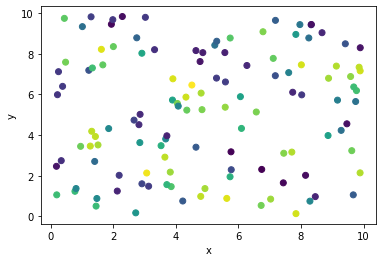

In [11]:
# Pick a little bit of data around some time to plot 
# The interpolation effort will be done by GP later, so no point interpolating now.
y_sel = y.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel)
plt.xlabel('x')
plt.ylabel('y')
# notice that the data looks sinusoidal

Text(0, 0.5, 't')

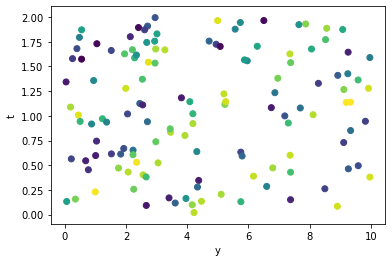

In [12]:
# Pick a little bit of data around some x,y to plot 
# The interpolation effort will be done by GP later, so no point interpolating now.
y_sel = y.where(np.logical_and(x.sel(coordinate='x')<1.5 , x.sel(coordinate='x')>0.5), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='x')<1.5 , x.sel(coordinate='x')>0.5), drop='true')

plt.scatter(x_sel.sel(coordinate='y'), x_sel.sel(coordinate='t'), c=y_sel)
plt.xlabel('y')
plt.ylabel('t')
# notice that the data is a wave that propogates towards larger y as time progresses

In [13]:
# Now lets choose some kernel for this data.
# Since we are trying to predict at scales that are much smaller than sinusoidal wave,
# using a simple smooth kernel should suffice.
# The excess of data points will ensure the periodicity 

# Further we might anticipate the length scales in the x,y,t direction might be different
# like was expected in Kuusela and Stein 2018
# So we design a kernel that is multiplication of the 3. 

#kernel = grg.kernels.ConstantKernel(0.1, ndim=3) * \
#        grg.kernels.ExpSquaredKernel([0.5, 0.5, 1], ndim=3)

kernel = 0.5*grg.kernels.ExpSquaredKernel([.5, .5, 0.5], ndim=3)

In [14]:
print(kernel.get_parameter_names())
print(kernel.get_parameter_vector())

# Note that in this case M is a 3X3 tensor, but since we are using the axis-aligned form
# only the elements along the diagonal (M_i_i) are non-zero.

('k1:log_constant', 'k2:metric:log_M_0_0', 'k2:metric:log_M_1_1', 'k2:metric:log_M_2_2')
[-1.79175947 -0.69314718 -0.69314718 -0.69314718]


In [15]:
test_x = np.array(np.meshgrid(np.linspace(0,1,20), 
                       np.linspace(0,1,10),
                       np.linspace(0,2,10)))

In [16]:
# Now lets start the GP process. 
# First we tell the GP what the kernel choice is. 
gp = grg.GP(kernel)
# At this point the GP knows nothing, except that the mean=0 and what the kernel is. 

In [25]:
# We can use this to draw some random samples from this multi-dimensional Gaussian 
# at a bunch of test points.
# We select them to be uniformly arranged, but that does not need to be the case.

test_pts = np.array(np.meshgrid(np.linspace(0,10,30), 
                       np.linspace(0,10,10),
                       np.linspace(0,2,10))).reshape(3,-1).T


In [26]:
test_pts = xr.DataArray(test_pts,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts.shape[0]), ['x','y','t']] ) 

In [27]:
# Before we proceed to do any fitting, we can see that with the initial parameters 
# we have defined a family of infinite functions. These can be sampled at the test points

samples = gp.sample(test_pts, 4)
# this step can be done properly using apply_ufunc
# These samples have been drawn from the prior (the distribution specified by us, where no knowledge of the input data is present).

In [28]:
samples = xr.DataArray(samples,  dims=["func_sample_num", "test_pt_num"])

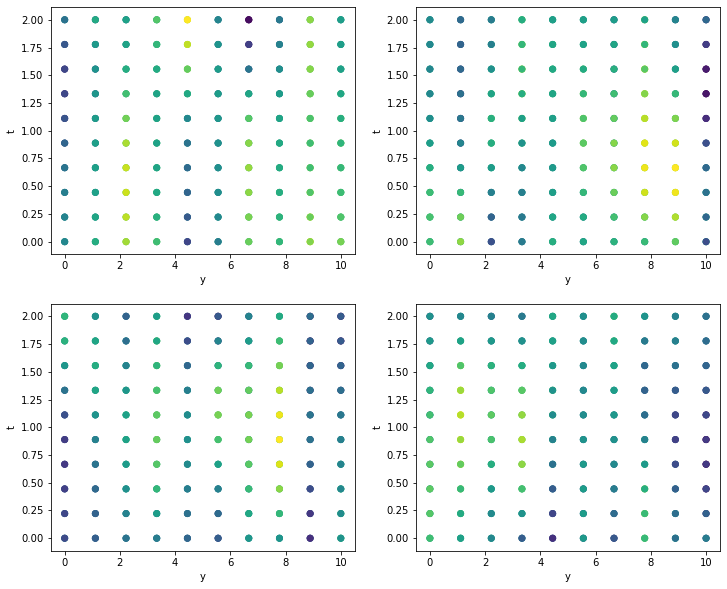

In [29]:
plt.figure(figsize=(12,10))
for i in range(4):
    
    plt.subplot(2,2,i+1)
    y_sel = samples.sel(func_sample_num=i).where(np.logical_and(test_pts.sel(coordinate='x')<2 ,
                                   test_pts.sel(coordinate='x')>0.8), drop='true')
    x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='x')<2 , 
                                   test_pts.sel(coordinate='x')>0.8), drop='true')

    plt.scatter(x_sel.sel(coordinate='y'), x_sel.sel(coordinate='t'), c=y_sel)
    plt.xlabel('y')
    plt.ylabel('t')
    
# Interesting shapes of functions have been samples. 
# Note that based on our prior choice of the kernel parameters, the functions
# are very smooth. Our "truth" function is much more wavy, so presumably when fitting
# the parameters the optimized length scales would be shrunk.

In [30]:
# Now let us set up the GP. 
# This is done by precomputing some covariance matrices, corresponding
# to the input data, and factorizing it
gp.compute(x, eta) 
# here we just set the random error to be the same as what we prescribed
# presumably, we can optimize for it (?)

In [31]:
pred, pred_var = gp.predict(y, test_pts, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred = xr.DataArray(pred,  dims={"test_pt_num"})
pred_var = xr.DataArray(pred_var,  dims={"test_pt_num"})

In [ ]:
# Write function to estimate the truth at more than the input points, using the input that
# was used to create the fake data.
# truth = 

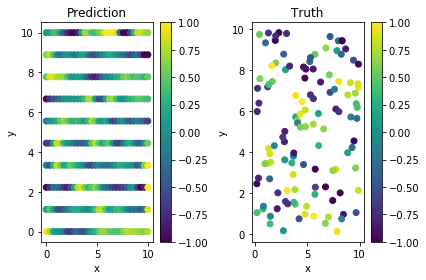

In [33]:
plt.subplot(121)
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8), drop='true')
x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction')

plt.subplot(122)
y_sel = y.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')

plt.tight_layout()

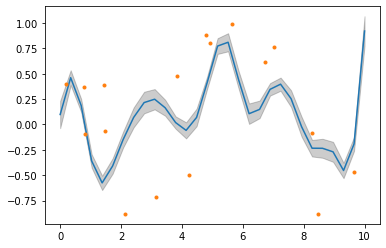

In [34]:
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var = pred_var.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                       , drop='true')

x_sel_input = x.where(np.logical_and(x.sel(coordinate='t')<1 , 
                                   x.sel(coordinate='t')>0.8) & 
                   np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                       , drop='true')

y_sel_input = y.where(np.logical_and(x.sel(coordinate='t')<1 ,
                                   x.sel(coordinate='t')>0.8) & 
                       np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                   , drop='true')

plt.fill_between(x_sel.sel(coordinate='x'), y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='x'), y_sel)
plt.plot(x_sel_input.sel(coordinate='x'), y_sel_input, '.')

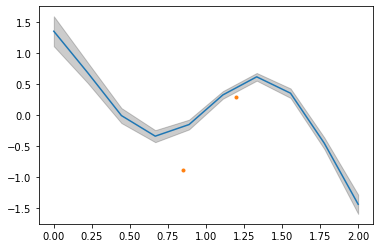

In [35]:
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var = pred_var.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 , 
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                       , drop='true')

x_sel_input = x.where(np.logical_and(x.sel(coordinate='x')<2.2, 
                                   x.sel(coordinate='x')>1.9) & 
                   np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                       , drop='true')

y_sel_input = y.where(np.logical_and(x.sel(coordinate='x')<2.2 ,
                                   x.sel(coordinate='x')>1.9) & 
                       np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                   , drop='true')

plt.fill_between(x_sel.sel(coordinate='t'), y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='t'), y_sel)
plt.plot(x_sel_input.sel(coordinate='t'), y_sel_input, '.')

In [36]:
# Since we chose kernel parameters that were good guesses, we got decent fits.
# The functions look sort of like sinusoidals.
# Can we do better? 
# Interesting to note that the sinusoidal behavior came in because the input data had that structure,
# the kernal did not have any idea about periodicity. 

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
# Does this not have to be less than 1? 

Initial ln-likelihood: -8295.06


In [37]:
# We use scipy's gradient descent minimizer to minimize. Since we want to maximize the likelihood, 
# minimizing the -log(likelihood) works too. This is what is known as maximum likelihood estimate. 
# There are other ways to do this, like the MCMC - which is an approach where the uncertainity
# in the "best" parameters is also expressed. 

from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [38]:
%time result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)
# this is the minimized set of parameters
# This takes a long time. (how does the time for this scale?)

CPU times: user 12.5 s, sys: 388 ms, total: 12.9 s
Wall time: 7.94 s
      fun: 135.21515205745777
 hess_inv: array([[0.01777274, 0.00494454, 0.00506832, 0.00503723],
       [0.00494454, 0.00363482, 0.00108226, 0.00061331],
       [0.00506832, 0.00108226, 0.00320428, 0.00087731],
       [0.00503723, 0.00061331, 0.00087731, 0.00367922]])
      jac: array([-1.55966330e-07, -4.81399360e-06,  9.09245637e-06, -1.15170405e-06])
  message: 'Optimization terminated successfully.'
     nfev: 25
      nit: 20
     njev: 25
   status: 0
  success: True
        x: array([-0.47187503,  0.94328557,  0.17660156, -2.67876366])


In [39]:
# Let's set the parameters to be these new ones, derived from MLE
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
# note that this final likelihood is bigger than what we started with. This
# is good since we wanted to maximize. 



Final ln-likelihood: -135.22


In [40]:
pred_MLE, pred_var_MLE = gp.predict(y, test_pts, return_var=True)
# Here the new prediction is made using the MLE parameter estimates.
pred_MLE = xr.DataArray(pred_MLE,  dims={"test_pt_num"})
pred_var_MLE = xr.DataArray(pred_var_MLE,  dims={"test_pt_num"})

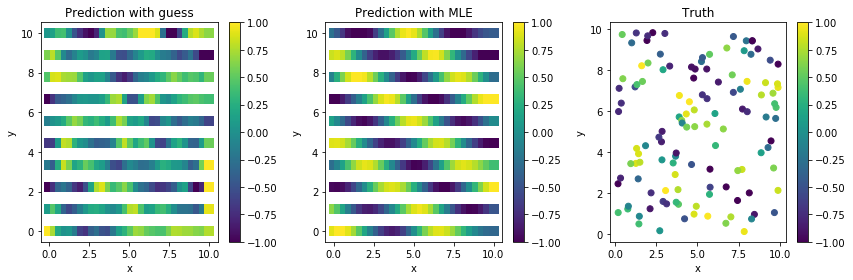

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(131)
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8), drop='true')
x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1, s=100, marker="s", edgecolor="none",)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction with guess')

plt.subplot(132)
y_sel = pred_MLE.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8), drop='true')
x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1, s=100, marker="s", edgecolor="none",)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction with MLE')

plt.subplot(133)
y_sel = y.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')

plt.tight_layout()

# Pretty damn good, huh?

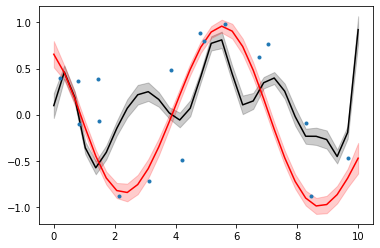

In [42]:
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var = pred_var.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_sel_MLE = pred_MLE.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var_MLE = pred_var_MLE.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                       , drop='true')

x_sel_input = x.where(np.logical_and(x.sel(coordinate='t')<1 , 
                                   x.sel(coordinate='t')>0.8) & 
                   np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                       , drop='true')

y_sel_input = y.where(np.logical_and(x.sel(coordinate='t')<1 ,
                                   x.sel(coordinate='t')>0.8) & 
                       np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                   , drop='true')

plt.fill_between(x_sel.sel(coordinate='x'), y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='x'), y_sel, color='k')

plt.fill_between(x_sel.sel(coordinate='x'), y_sel_MLE - np.sqrt(y_var_MLE), y_sel_MLE + np.sqrt(y_var_MLE),
                color="r", alpha=0.2)
plt.plot(x_sel.sel(coordinate='x'), y_sel_MLE, color='r')

plt.plot(x_sel_input.sel(coordinate='x'), y_sel_input, '.')

# Pretty damn good, huh?

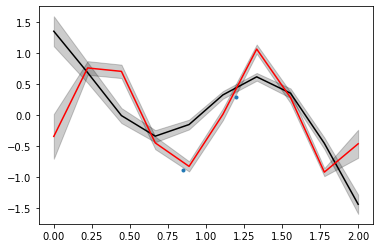

In [43]:
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var = pred_var.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_sel_MLE = pred_MLE.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var_MLE = pred_var_MLE.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 , 
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                       , drop='true')

x_sel_input = x.where(np.logical_and(x.sel(coordinate='x')<2.2, 
                                   x.sel(coordinate='x')>1.9) & 
                   np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                       , drop='true')

y_sel_input = y.where(np.logical_and(x.sel(coordinate='x')<2.2 ,
                                   x.sel(coordinate='x')>1.9) & 
                       np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                   , drop='true')

plt.fill_between(x_sel.sel(coordinate='t'), y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='t'), y_sel, color='k')

plt.fill_between(x_sel.sel(coordinate='t'), y_sel_MLE - np.sqrt(y_var_MLE), y_sel_MLE + np.sqrt(y_var_MLE),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='t'), y_sel_MLE, color='r')

plt.plot(x_sel_input.sel(coordinate='t'), y_sel_input, '.')

# Pretty damn good, huh?

In [47]:
print(gp.parameter_names)
print(np.exp(gp.parameter_vector))
# Length scales associated with the x,y directions are 2.5, 1.2 
# this is good since we chose a lower mode structure in x than y.
# Also the time scale is 0.06, which also great since omega even bigger than k,l. 
# This is good, and implies that there is some physical value in the parameters that
# resulted. 

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1', 'kernel:k2:metric:log_M_2_2')
[1.00000000e+00 1.25000000e-12 6.23831467e-01 2.56840624e+00
 1.19315560e+00 6.86479738e-02]


In [ ]:
# Here we got pretty far from using the exponential kernel. This is because 
# the origional function is very smooth - the power spectrum is only delta function at k,l, omega. 
# However, most natural data will not be like this - it generally has some sort of piecewise powerspectrum. If anything,
# this kernal might have made the function rougher than what we entered in. 

## Now towards Argo data

In [94]:
## Argo data 
ds = xr.open_dataset('anom_data.nc')
num_samples = len(ds.r)
Xinput = np.zeros((num_samples, 3)) # 3 coordinates for lon, lat, time
Xinput[:,0] = ds.Lon.values
Xinput[:,1] = ds.Lat.values
Xinput[:,2] = ds.Time.values
Xinput[:,2] = Xinput[:,2]/1e9/24/3600 # convert to day
Yinput = ds.Data.isel(c=0).values

Xinput = xr.DataArray(Xinput, dims=["samplenum", "coordinate"], coords=[range(num_samples), ['lon','lat','time']]).rename('Input_coordinates')
Yinput = xr.DataArray(Yinput, dims=["samplenum"]).rename('Anomaly_data')

Argo_input = xr.merge([Xinput, Yinput])

Argo_input

<xarray.Dataset>
Dimensions:            (coordinate: 3, samplenum: 4089)
Coordinates:
  * samplenum          (samplenum) int64 0 1 2 3 4 ... 4084 4085 4086 4087 4088
  * coordinate         (coordinate) <U4 'lon' 'lat' 'time'
Data variables:
    Input_coordinates  (samplenum, coordinate) float64 -144.4 ... 1.741e+04
    Anomaly_data       (samplenum) float64 -0.2994 -0.2045 ... -0.3255 -0.5773

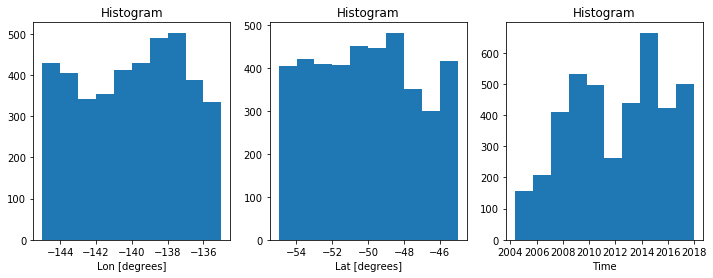

In [56]:
plt.figure(figsize=(12,4))

plt.subplot(131)
ds.Lon.plot.hist();

plt.subplot(132)
ds.Lat.plot.hist();

plt.subplot(133)
ds.Time.plot.hist();

In [57]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

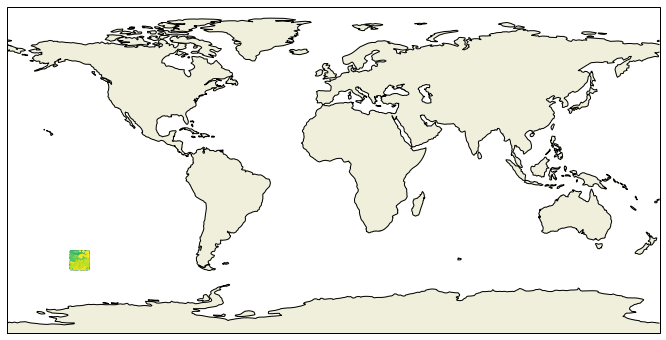

In [91]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

#ax.plot(ds.Lon, ds.Lat,  transform=ccrs.PlateCarree())
ax.scatter(Argo_input.Input_coordinates.sel(coordinate='lon'), 
         Argo_input.Input_coordinates.sel(coordinate='lat'), 
         c=Argo_input.Input_coordinates.sel(coordinate='time')/1e9/24/3600/360+1970, 
           s=1,  transform=ccrs.PlateCarree())
#plt.colorbar()
ax.coastlines()
ax.set_boundary
ax.add_feature(cfeature.LAND)
ax.xlim()
#ax.gridlines(draw_labels=True);

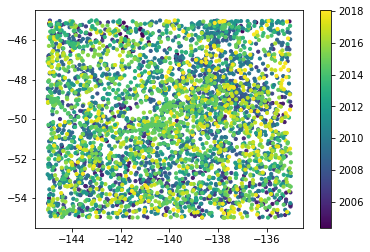

In [92]:
plt.scatter(Argo_input.Input_coordinates.sel(coordinate='lon'), 
         Argo_input.Input_coordinates.sel(coordinate='lat'), 
         c=Argo_input.Input_coordinates.sel(coordinate='time')/365+1970, 
           s=10)
plt.colorbar()
# The not sure of the best way to color by date, so used this approximate version.

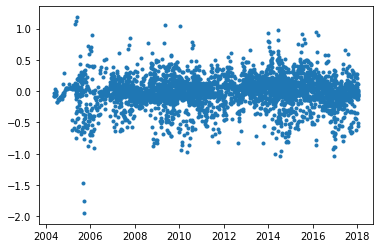

In [99]:
plt.scatter(Argo_input.Input_coordinates.sel(coordinate='time')/365+1970, 
         Argo_input.Anomaly_data, marker='.')

In [113]:
np.var(Argo_input.Anomaly_data).values

array(0.05685241)

In [114]:
Lxscale = 110e3*np.sin(2*np.pi/360*50)
Lyscale = 110e3

kernel_argo = np.var(Argo_input.Anomaly_data).values*grg.kernels.ExpSquaredKernel([100e3**2/Lxscale**2, 
                                                100e3**2/Lyscale**2, 
                                                30**2
                                               ], ndim=3)
# Let's start with a simple exponential squared kernel. 
# Also just set the prior to have isotropic dependence in space

In [115]:
print(kernel_argo.get_parameter_names())
print(kernel_argo.get_parameter_vector())

('k1:log_constant', 'k2:metric:log_M_0_0', 'k2:metric:log_M_1_1', 'k2:metric:log_M_2_2')
[-3.96590893  0.34240982  0.34240982  6.80239476]


In [116]:
gp_argo = grg.GP(kernel_argo)

In [117]:
test_pts_argo = np.array(np.meshgrid(np.linspace(-144,-136,30), 
                       np.linspace(-54,-46,30),
                       (2016-1970)*365)).reshape(3,-1).T
# Just chose a single test point in time for now, but it doesn't matter.

In [118]:
test_pts_argo = xr.DataArray(test_pts_argo,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo.shape[0]), ['lon','lat','time']] ) 

In [119]:
samples_argo = gp_argo.sample(test_pts_argo, 4)

In [120]:
samples_argo = xr.DataArray(samples_argo,  dims=["func_sample_num", "test_pt_num"])

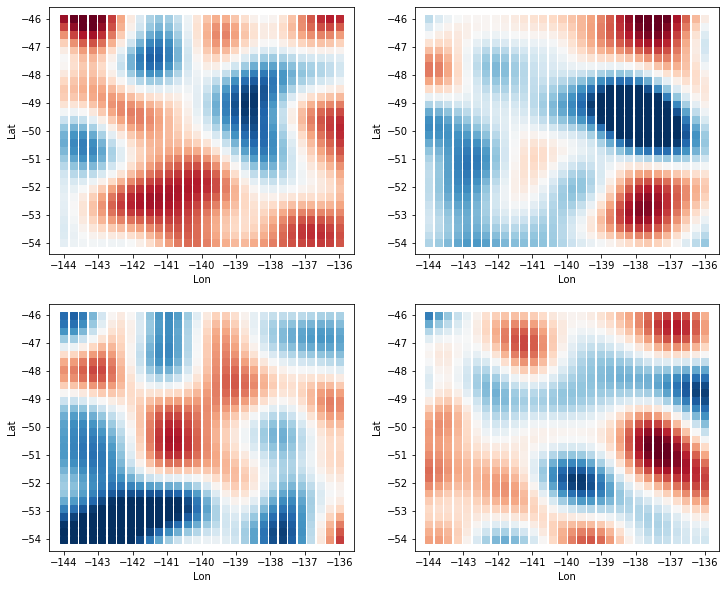

In [210]:
plt.figure(figsize=(12,10))
for i in range(4):
    
    plt.subplot(2,2,i+1)

    plt.scatter(test_pts_argo.sel(coordinate='lon'), 
                test_pts_argo.sel(coordinate='lat'),
                c=samples_argo.sel(func_sample_num=i),
                s=50, marker='s', vmin=-0.5, vmax=0.5, cmap='RdBu_r')
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    
# Since we set the length scales to be 100km, we get an eddy field
# with approximately that size in the prior set of functions.

In [125]:
# Now let us set up the GP. 

gp_argo.compute(Argo_input.Input_coordinates, 0.01)
# not sure what to set as ob error. 

In [128]:
pred_argo, pred_var_argo = gp_argo.predict(Argo_input.Anomaly_data, test_pts_argo, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred_argo = xr.DataArray(pred_argo,  dims={"test_pt_num"})
pred_var_argo = xr.DataArray(pred_var_argo,  dims={"test_pt_num"})

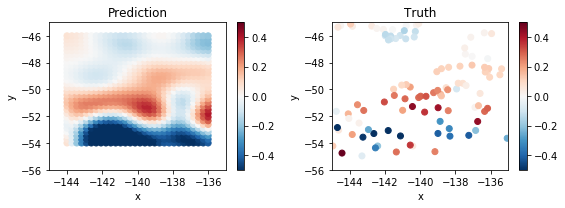

In [178]:
plt.figure(figsize=(8,3))
plt.subplot(121)

plt.scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.subplot(122)
x_sel = Argo_input.Input_coordinates.where(np.logical_and(Argo_input.Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
                                drop='true')

y_sel = Argo_input.Anomaly_data.where(np.logical_and(Argo_input.Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
                                drop='true')

plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.tight_layout()


In [137]:
print("Initial ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Argo_input.Anomaly_data)))

Initial ln-likelihood: -127.41


In [143]:
def neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.log_likelihood(Argo_input.Anomaly_data)

def grad_neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.grad_log_likelihood(Argo_input.Anomaly_data)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [144]:
%time result_argo = minimize(neg_ln_like_argo,gp_argo.get_parameter_vector(), jac=grad_neg_ln_like_argo)

CPU times: user 4min 46s, sys: 12.8 s, total: 4min 59s
Wall time: 3min 48s


In [146]:
print(result_argo)

      fun: -2385.7689687246443
 hess_inv: array([[ 9.68951465e-04,  4.11523351e-04,  4.97797353e-04,
         3.05019467e-04],
       [ 4.11523351e-04,  1.85557016e-03, -4.52235407e-05,
        -4.19158430e-04],
       [ 4.97797353e-04, -4.52235407e-05,  2.21163627e-03,
        -6.07470640e-04],
       [ 3.05019467e-04, -4.19158430e-04, -6.07470640e-04,
         1.65827541e-03]])
      jac: array([ 2.99153081e-07, -5.57215571e-08,  6.28488124e-08, -1.59470574e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 12
     njev: 18
   status: 0
  success: True
        x: array([-3.85259319,  0.2722026 , -0.92450228,  6.2817012 ])


In [148]:
gp_argo.set_parameter_vector(result_argo.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Argo_input.Anomaly_data)))



Final ln-likelihood: 2385.77


In [149]:
pred_MLE_argo, pred_var_MLE_argo = gp_argo.predict(Argo_input.Anomaly_data, test_pts_argo, return_var=True)
# Here the new prediction is made using the MLE parameter estimates.
pred_MLE_argo = xr.DataArray(pred_MLE_argo,  dims={"test_pt_num"})
pred_var_MLE_argo = xr.DataArray(pred_var_MLE_argo,  dims={"test_pt_num"})

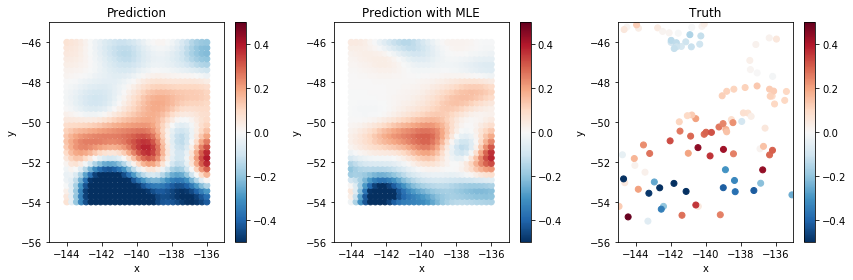

In [177]:
plt.figure(figsize=(12,4))
plt.subplot(131)

plt.scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.subplot(132)

plt.scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_MLE_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction with MLE')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.subplot(133)
x_sel = Argo_input.Input_coordinates.where(np.logical_and(Argo_input.Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
                                drop='true')

y_sel = Argo_input.Anomaly_data.where(np.logical_and(Argo_input.Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
                                drop='true')

plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.tight_layout()


In [201]:
# What about a time series prediction.
# Make 
test_pts_argo2 = np.array(np.meshgrid(np.linspace(-144,-136,30), 
                       -50,
                       np.linspace((2013-1970)*365, (2019-1970)*365, 120)
                                     )).reshape(3,-1).T


In [202]:
test_pts_argo2 = xr.DataArray(test_pts_argo2,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo2.shape[0]), ['lon','lat','time']] ) 

In [203]:
pred_MLE_argo2, pred_var_MLE_argo2 = gp_argo.predict(Argo_input.Anomaly_data, test_pts_argo2, return_var=True)
# Here the new prediction is made using the MLE parameter estimates.
pred_MLE_argo2 = xr.DataArray(pred_MLE_argo2,  dims={"test_pt_num"})
pred_var_MLE_argo2 = xr.DataArray(pred_var_MLE_argo2,  dims={"test_pt_num"})

(2013, 2019)

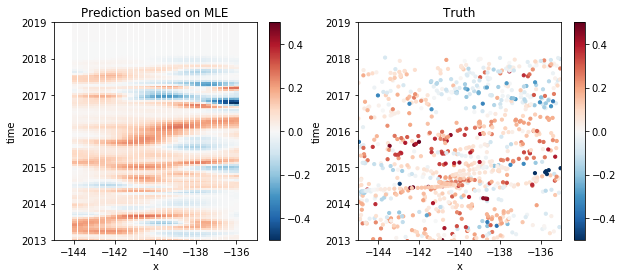

In [206]:
plt.figure(figsize=(10,4))
plt.subplot(121)

plt.scatter(test_pts_argo2.sel(coordinate='lon'), 
            test_pts_argo2.sel(coordinate='time')/365 + 1970 , 
            c=pred_MLE_argo2, vmin=-.5, vmax=.5, s=15, marker='s', cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('time')
plt.colorbar()
plt.xlim([-145, -135])
plt.ylim([2013, 2019])
plt.title('Prediction based on MLE')

plt.subplot(122)
x_sel = Argo_input.Input_coordinates.where(np.logical_and(
                               Argo_input.Input_coordinates.sel(coordinate='time')<(2019-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2013-1970)*365-60) & 
                                           np.logical_and(
                                Argo_input.Input_coordinates.sel(coordinate='lat')<-48, 
                                Argo_input.Input_coordinates.sel(coordinate='lat')>-52), 
                                drop='true')

y_sel = Argo_input.Anomaly_data.where(np.logical_and(
                               Argo_input.Input_coordinates.sel(coordinate='time')<(2019-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2013-1970)*365-60) & 
                                           np.logical_and(
                                Argo_input.Input_coordinates.sel(coordinate='lat')<-48, 
                                Argo_input.Input_coordinates.sel(coordinate='lat')>-52), 
                                drop='true')
plt.scatter(x_sel.sel(coordinate='lon'), 
            x_sel.sel(coordinate='time')/365 + 1970, 
            c=y_sel, vmin=-.5, vmax=.5, s=10, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('time')
plt.colorbar()
plt.title('Truth')
plt.xlim([-145, -135])
plt.ylim([2013, 2019])
# A bit hard to see, but some sign of eastward propogation is visible.
# Also since the data ends in 2018, the prediction after that is just 0.

Text(0.5, 1.0, 'Prediction based on MLE')

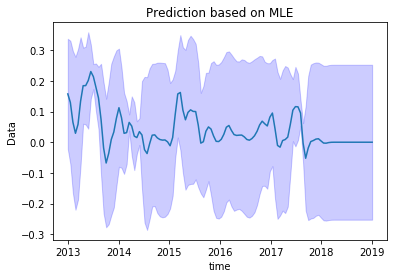

In [207]:
x_sel = test_pts_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')
y_sel = pred_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')
y_var = pred_var_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')

plt.fill_between(x_sel.sel(coordinate='time')/365 + 1970, 
                 y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="b", alpha=0.2)
plt.plot(x_sel.sel(coordinate='time')/365 + 1970, y_sel)
#plt.scatter(test_pts_argo2.sel(coordinate='lon'), 
#            test_pts_argo2.sel(coordinate='time')/365 + 1970 , 
#            c=pred_MLE_argo2, vmin=-.5, vmax=.5, s=15, marker='s', cmap='RdBu_r')
plt.ylabel('Data')
plt.xlabel('time')

plt.title('Prediction based on MLE')

# The prediction of the time series is relatively poor,
# but considering the limited amount of data it is probably not bad.

In [208]:
# Did the MLE change the length scales that we had guessed?
print(gp_argo.parameter_names)
print(np.exp(gp_argo.parameter_vector))

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1', 'kernel:k2:metric:log_M_2_2')
[1.00000000e+00 1.25000000e-12 2.12246256e-02 1.31285296e+00
 3.96728830e-01 5.34697520e+02]


In [209]:
print('Lx(km)='+str((np.exp(gp_argo.parameter_vector[3])*Lxscale**2)**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_argo.parameter_vector[4])*Lyscale**2)**0.5/1e3))
print('Timescale(km)='+str((np.exp(gp_argo.parameter_vector[5]))**0.5))

# These are sensible numbers
# Notice that the method has made the Lx > Ly, and also shrunk the timescale a bit.

Lx(km)=96.55053760132799
Ly(km)=69.2850549595115
Timescale(km)=23.123527404536343


## Change to a proper Matern Kernel based on QG theory. 

In [ ]:
...